In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pinns import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

## Brusselator PDEs

> The Brusselator PDEs for two species are
<h3><center>$\partial_t u = D_u (\partial_x^2 + \partial_y^2)u + A - (B+1)u + u^2v$</center></h3>

<h3><center>$\partial_t v = D_v (\partial_x^2 + \partial_y^2)v + Bu - u^2 v$</center></h3>

for diffusion constants $D_u$, $D_v$, and model parameters $A, B > 0$.
Therefore, the kinetic terms are

<h3><center>$f(u,v) = A - (B+1)u + u^2v$</center></h3>
<h3><center>$g(u,v) = Bu - u^2 v$</center></h3>

<h3><center>$u^* = A$</center></h3>
<h3><center>$v^* = \frac{B}{A}$</center></h3>



In [3]:
import pickle

with open('./turing_Brusselator_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:
#with open('./turing_Brusselator_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
    sol = np.load(f)
    
with open('./turing_Brusselator_params_d_t_0_01_n_32_L_0_50_T_10000.npy', 'rb') as f:
#with open('./turing_Brusselator_params_2_d_t_0_01_n_32_L_0_50_T_5000.npy', 'rb') as f:    
#with open('./turing_Brusselator_params_3_d_t_0_01_n_32_L_4_00_T_1000.npy', 'rb') as f:
    params = pickle.load(f)

In [4]:
sol.shape, params

((3, 2, 1024),
 {'D_U': 0.0016,
  'D_V': 0.0135,
  'A': 4.0,
  'B': 11.0,
  'n': 32,
  'delta_t': 0.01,
  'Lx': 0.5,
  'Ly': 0.5,
  'T': 10000})

In [5]:
runs = []
for noise in [.05, .10, .15, .2]:
    
    print("============================================")
    print(f"        noise:{noise*100}%")
    print()
    torch.manual_seed(42)
    np.random.seed(42)

    D_U = params["D_U"]#
    D_V = params["D_V"]#

    x = torch.linspace(0, params["Lx"], params["n"], device=dev_str)
    y = torch.linspace(0, params["Ly"], params["n"], device=dev_str)
    X,Y = torch.meshgrid(x, y, indexing='ij')
    data_X = torch.vstack([X.flatten(), Y.flatten()]).T
    # To turn the tensor to a leaf node, we detach and clone it here
    data_X = data_X.detach().clone()
    data_X.requires_grad = True

    # data_x = torch.linspace(0, params["Lx"], 128).to(device)
    # data_y = torch.linspace(0, params["Ly"], 128).to(device)
    # X,Y = torch.meshgrid(x, y, indexing='ij')
    # physics_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)


    u_actual = sol[-1, 0, :]
    v_actual = sol[-1, 1, :]
    u_noisy = u_actual + np.random.normal(0, 1, params["n"]**2)*noise*(np.max(u_actual) - np.min(u_actual))
    v_noisy = v_actual + np.random.normal(0, 1, params["n"]**2)*noise*(np.max(v_actual) - np.min(v_actual))
    data_U = torch.from_numpy(u_noisy)
    data_V = torch.from_numpy(v_noisy)
    data_f = torch.vstack([data_U, data_V]).T.to(device)

    N = params["n"]**2
    domain_bounds = torch.tensor([params["Lx"], params["Ly"]]).to(device)


    A = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
    sampled_As = []
    B = torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
    sampled_Bs = []




    lb = torch.tensor([0., 0.]).to(device)
    ub = torch.tensor([params["Lx"], params["Ly"]]).to(device)
    model = Net_dense_normalised([2, 128, 128, 128, 128, 2], lb, ub).to(device)

    # optimizer = torch.optim.Adam([
    #                              {'params': model.parameters()},
    #                              {'params': [A, B], 'lr': 0.01}],
    #                              lr=1e-4, weight_decay=0.0001)
    optimizer = torch.optim.Adam([
                                 {'params': model.parameters()},
                                 {'params': [A, B], 'lr': 0.01}],
                                 lr=1e-4, weight_decay=0.0001)
    epochs = 200000
    loss_data = 0.0
    lambda_data = 1.0#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#1.0
    loss_physics = 0.0
    lambda_physics = 1e-1#torch.nn.Parameter(torch.ones(1, device=f"{device.type}:{device.index}"))*0.5#5e-2


    losses = np.zeros((2, epochs))

    for i in range(epochs):
        optimizer.zero_grad()

        #################################
        # data loss
        # randomly select 1/4th of them
        random_indices = torch.randperm(data_X.shape[0])[:N//128]
        data_f_hat = model(data_X[random_indices,:]).squeeze()
        loss_data = torch.mean((data_f[random_indices,:] - data_f_hat)**2)


        #################################
        # physics derivatives
        # random points from U(0,1)
        # When multiplied with Lx and Ly
        physics_X = torch.rand((N,2), requires_grad=True ,device=dev_str)*domain_bounds    
        physics_f = model(physics_X).squeeze()
        U = physics_f[:,0]
        V = physics_f[:,1]
        dxy  = torch.autograd.grad(U, physics_X, torch.ones_like(U), create_graph=True)[0]# computes dy/dx
        dx, dy = dxy[:,0], dxy[:,1]
        dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
        dx2 =  dxy2[:,0]
        dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
        dy2 =  dyx2[:,1]
        laplacianU = dx2 + dy2

        dxy  = torch.autograd.grad(V, physics_X, torch.ones_like(V), create_graph=True)[0]# computes dy/dx
        dx, dy = dxy[:,0], dxy[:,1]
        dxy2 = torch.autograd.grad(dx, physics_X, torch.ones_like(dx), create_graph=True)[0]# computes d^2u/dx^2
        dx2 =  dxy2[:,0]
        dyx2 = torch.autograd.grad(dy, physics_X, torch.ones_like(dy), create_graph=True)[0]# computes d^2u/dy^2
        dy2 =  dyx2[:,1]
        laplacianV = dx2 + dy2


        FU = torch.exp(A) - (torch.exp(B) + 1) * U + U*U*V
        FV = torch.exp(B) * U - U*U*V

        dudt = D_U * laplacianU + FU
        dvdt = D_V * laplacianV + FV
        ################################
        # physics loss
        # Construct the physics loss here
        loss_physics = torch.mean(dudt**2 + dvdt**2)    

        total_loss = (
            +lambda_data*loss_data
            +lambda_physics*loss_physics        
                        )

        total_loss.backward(retain_graph=True)
        optimizer.step()

        losses[:,i] = (loss_data.item(), loss_physics.item())
        sampled_As.append(A.item())
        sampled_Bs.append(B.item())

    #     a, b = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
    #     a2,b2 = 64*10*a, b
    #     lambda_physics = a2/(a2+b2)
    #     lambda_data = 1.0 - lambda_physics
    #     grad_data, grad_phy = torch.sum(data_X.grad**2).item(), torch.sum(physics_X.grad**2).item()
    #     loss_data, loss_phy = losses[0,i], losses[1,i]
    #     w1 = loss_data**2/np.sqrt(grad_data)
    #     w2 = loss_phy**2/np.sqrt(grad_phy)
    #     lambda_physics = w2/(w1+w2)
    #     lambda_data = 1.0 - lambda_physics



        if i%25000 == 0:
            print(f"Epoch: {i}")
            print(f"loss data: {losses[0,i]:.6f}, loss physics: {losses[1,i]:.6f}")
            print(f"A: {np.exp(sampled_As[-1]):.4f}, B: {np.exp(sampled_Bs)[-1]:.4f}")
    #         print(f"grad_data: {grad_data:.10f}, grad_physics: {grad_phy:.10f}")
    #         print(f"lambda_data: {lambda_data:.6f}, lambda_physics: {lambda_physics:.6f}")

    runs.append({
        'noise': noise,
        'losses': losses,
        'sampled_As':sampled_As,
        'sampled_Bs':sampled_Bs,
        'model':model,
        'u_noisy':u_noisy,
        'v_noisy':v_noisy,
    }
    )

        noise:5.0%

Epoch: 0
loss data: 12.446889, loss physics: 5.486112
A: 2.6912, B: 2.7456
Epoch: 25000
loss data: 6.401155, loss physics: 0.266329
A: 4.0169, B: 9.3406
Epoch: 50000
loss data: 6.735396, loss physics: 1.135530
A: 4.3553, B: 8.9936
Epoch: 75000
loss data: 0.584924, loss physics: 3.737836
A: 4.1892, B: 8.8533
Epoch: 100000
loss data: 0.294282, loss physics: 2.321615
A: 4.2532, B: 9.5426
Epoch: 125000
loss data: 0.169319, loss physics: 1.046958
A: 4.1094, B: 10.4597
Epoch: 150000
loss data: 0.137239, loss physics: 0.642467
A: 4.1538, B: 10.7720
Epoch: 175000
loss data: 0.113247, loss physics: 0.275492
A: 4.0546, B: 10.8996
        noise:10.0%

Epoch: 0
loss data: 13.023971, loss physics: 5.486112
A: 2.6912, B: 2.7456
Epoch: 25000
loss data: 5.846308, loss physics: 0.370076
A: 4.0614, B: 9.3179
Epoch: 50000
loss data: 8.055941, loss physics: 0.915187
A: 4.2771, B: 9.2653
Epoch: 75000
loss data: 0.809270, loss physics: 3.680373
A: 4.2275, B: 8.7980
Epoch: 100000
loss dat

        noise:5.0%



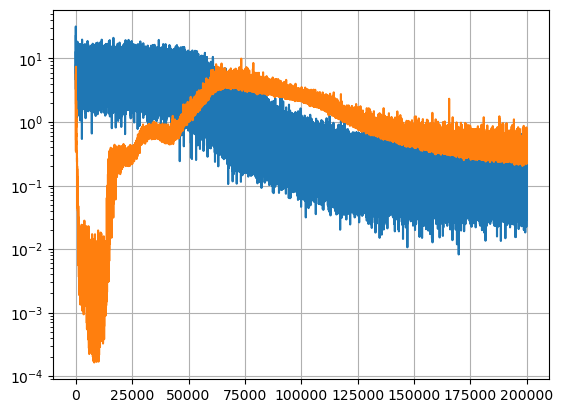

4.083624391241508 10.962122221771741 198082


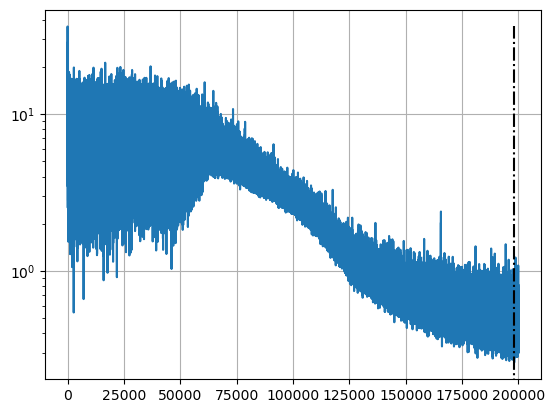

        noise:10.0%



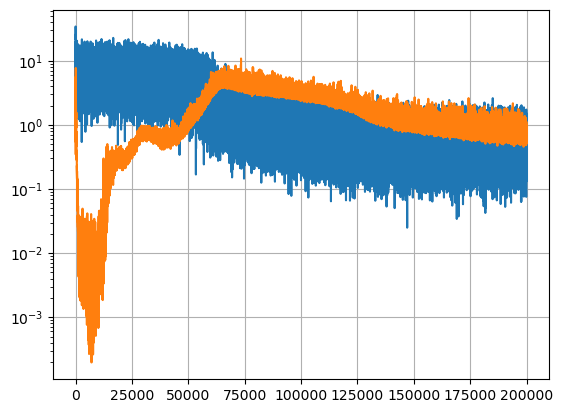

4.099056993252299 9.640983816099343 2698


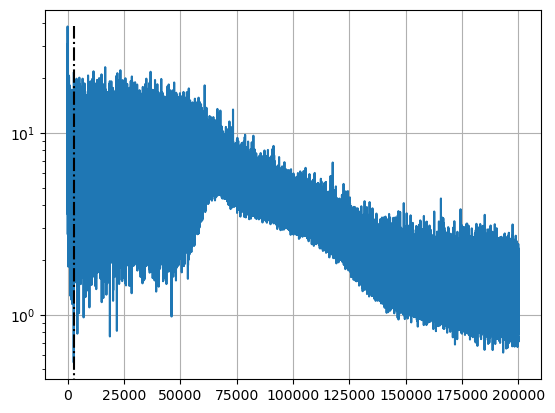

        noise:15.0%



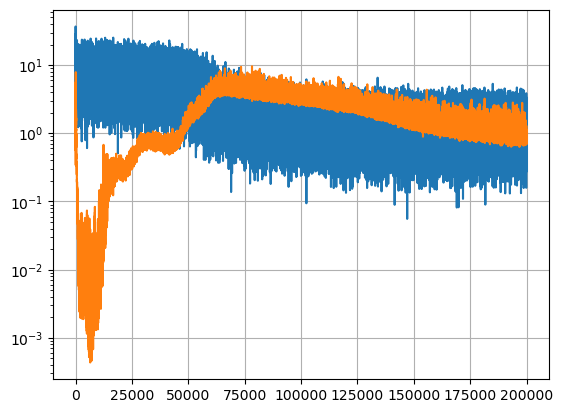

3.9904760587962165 9.457813187654056 5051


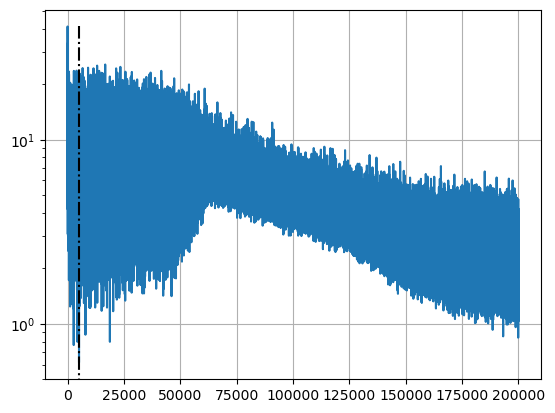

        noise:20.0%



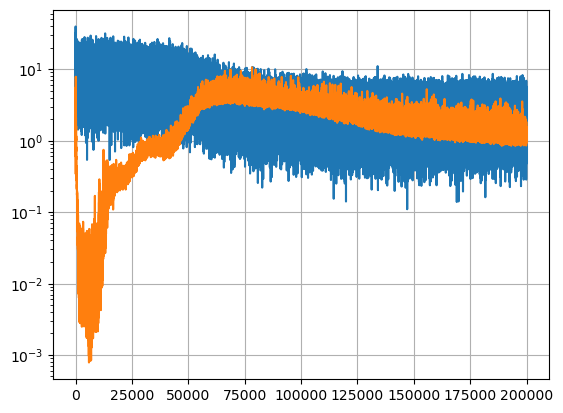

4.026433178137527 9.524474655059398 5051


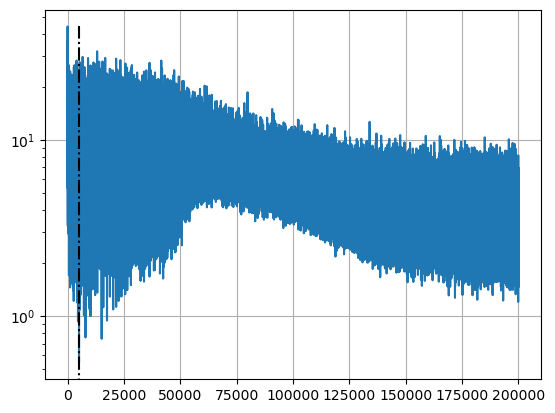

In [7]:
for items in runs:
    noise = items['noise']
    losses = items['losses']
    sampled_As = items['sampled_As']
    sampled_Bs = items['sampled_Bs']
    print("============================================")
    print(f"        noise:{noise*100}%")
    print()
    plt.plot(losses[0,:])
    plt.plot(losses[1,:])
    plt.yscale('log');plt.grid(); plt.show()
    plt.plot(np.sum(losses, axis=0))

    index = np.argmin(np.sum(losses, axis=0)[20:])
    print(np.exp(sampled_As[index]), np.exp(sampled_Bs[index]), index)
    plt.yscale('log'); plt.vlines(index, 0, np.max(np.sum(losses, axis=0)),color='black', linestyles='-.');plt.grid();

    plt.show()

        noise:5.0%



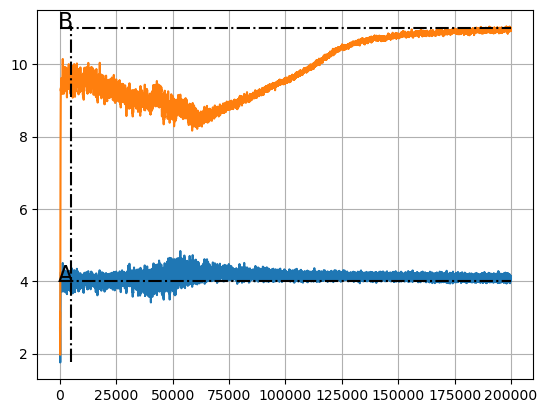

4.099572058147977 10.987741611687442
4.086706455164611 0.04952788952997885 10.935562819234432 0.03440989561985505
        noise:10.0%



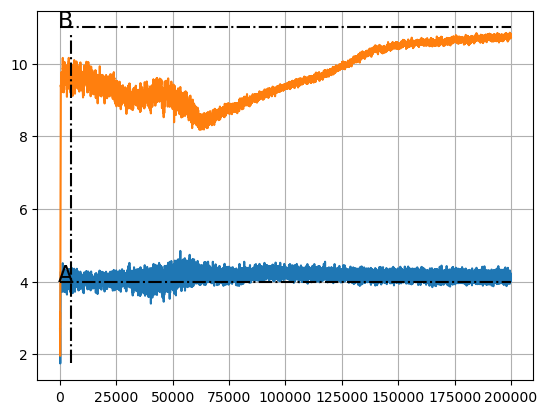

4.15184771130793 10.747276629756659
4.1277464890115505 0.08023419254209758 10.706706100407917 0.05136632641385716
        noise:15.0%



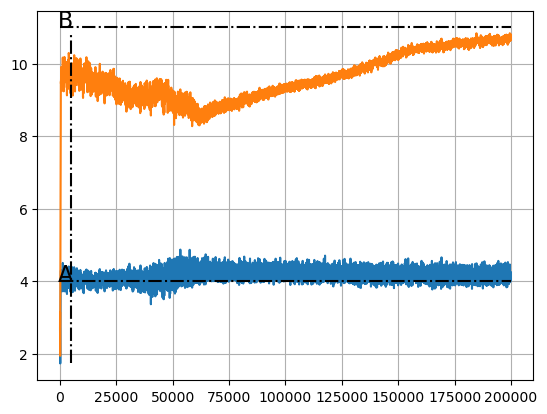

4.174980520625734 10.743018846985667
4.163285003403615 0.11185160916246643 10.629857330224029 0.07096766589058649
        noise:20.0%



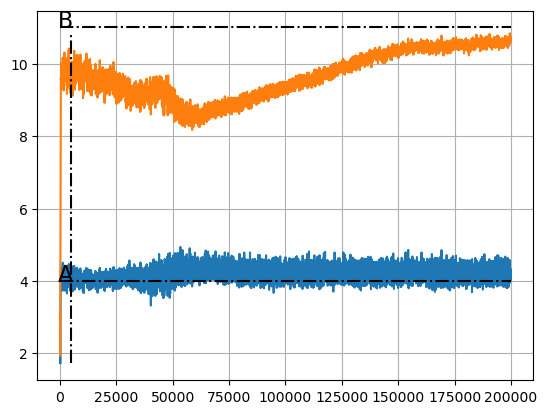

4.224530767050463 10.692311756244585
4.202178629218036 0.150724138459222 10.572235995017722 0.08270241133666086


In [9]:
for items in runs:
    noise = items['noise']
    losses = items['losses']
    sampled_As = items['sampled_As']
    sampled_Bs = items['sampled_Bs']
    print("============================================")
    print(f"        noise:{noise*100}%")
    print()
    plt.plot(np.exp(sampled_As))
    plt.plot(np.exp(sampled_Bs))
    plt.hlines(params["A"], 0, epochs, linestyles="-.", color="black")
    plt.annotate("A", (-1000, params["A"]), (-1000, params["A"]), fontsize=16)
    plt.hlines(params["B"], 0, epochs, linestyles="-.", color="black")
    plt.annotate("B", (-1000, params["B"]), (-1000, params["B"]), fontsize=16)
    plt.vlines(index, min(np.min(np.exp(sampled_As)),np.min(np.exp(sampled_Bs))), 
               max(np.max(np.exp(sampled_As)),np.max(np.exp(sampled_Bs)))
              ,color='black', linestyles='-.');plt.grid()
    plt.show()
    print(np.exp(sampled_As[-1]), np.exp(sampled_Bs[-1]))
    print(np.mean(np.exp(sampled_As[180000:])),np.std(np.exp(sampled_As[180000:])),
          np.mean(np.exp(sampled_Bs[180000:])), np.std(np.exp(sampled_Bs[180000:])))

        noise:5.0%



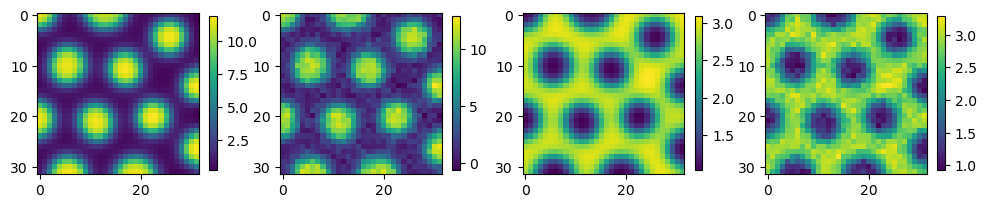

        noise:10.0%



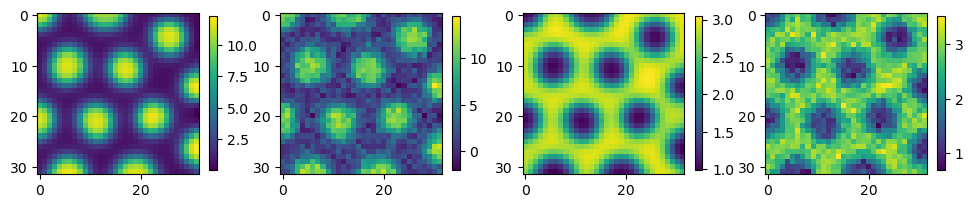

        noise:15.0%



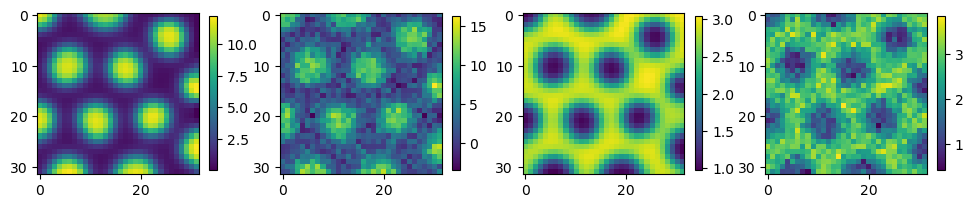

        noise:20.0%



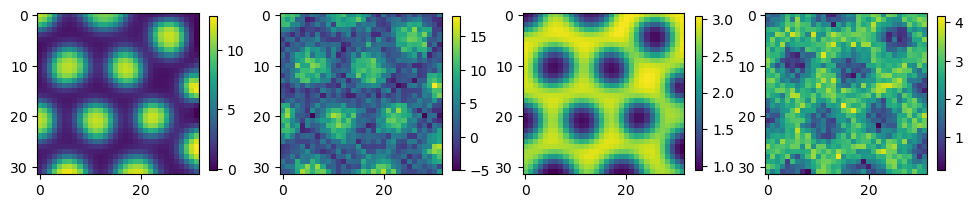

In [16]:
for items in runs:
    noise = items['noise']
    losses = items['losses']
    sampled_As = items['sampled_As']
    sampled_Bs = items['sampled_Bs']
    model = items['model']
    u_noisy = items['u_noisy'].reshape((32, 32))
    v_noisy = items['v_noisy'].reshape((32, 32))
    print("============================================")
    print(f"        noise:{noise*100}%")
    print()
    solution = model(data_X).cpu().detach()
    U_hat = solution[:, 0].reshape((32, 32))
    V_hat = solution[:, 1].reshape((32, 32))
    index = -1
    _ = plt.figure(figsize=(12,4))
    plt.subplot(141)
    plt.imshow(U_hat)
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(u_noisy)
    plt.colorbar(shrink=.5)
    plt.subplot(143)
    plt.imshow(V_hat)
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(v_noisy)
    plt.colorbar(shrink=.5)
    
    plt.show()

        noise:5.0%



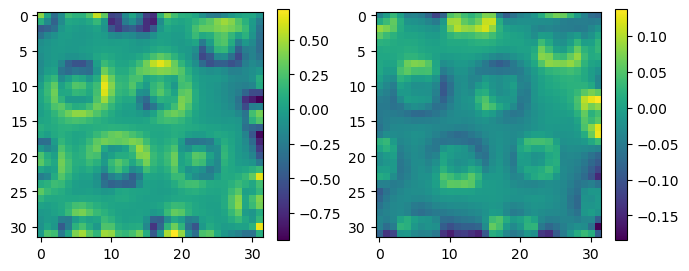

        noise:10.0%



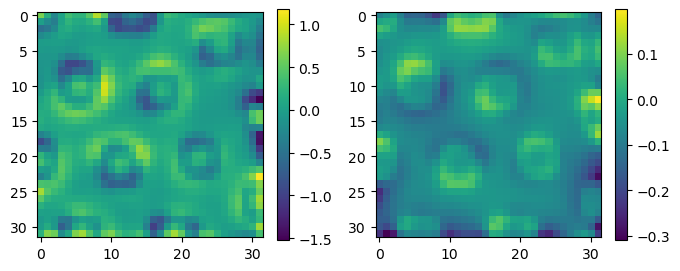

        noise:15.0%



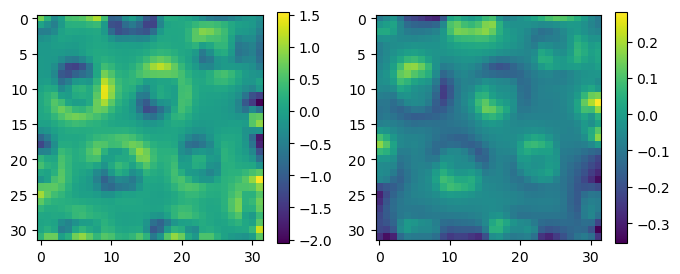

        noise:20.0%



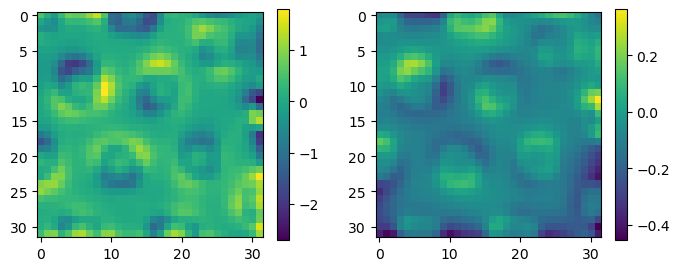

In [17]:
for items in runs:
    noise = items['noise']
    losses = items['losses']
    sampled_As = items['sampled_As']
    sampled_Bs = items['sampled_Bs']
    model = items['model']
    print("============================================")
    print(f"        noise:{noise*100}%")
    print()
    solution = model(data_X).cpu().detach()
    U_hat = solution[:, 0].reshape((32, 32))
    V_hat = solution[:, 1].reshape((32, 32))
    _ = plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.imshow(U_hat-sol[-1, 0, :].reshape((params["n"], params["n"])))
    plt.colorbar(shrink=.75)
    plt.subplot(122)
    plt.imshow(V_hat-sol[-1, 1, :].reshape((params["n"], params["n"])))
    plt.colorbar(shrink=.75)
    plt.show()